In [19]:
import pandas as pd
import numpy as np
import xarray as xr
# import all necessary libraries
import os
import warnings
from pathlib import Path

import cartopy.feature as cfeature
import geodatasets
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import xarray as xr
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from utils.eda_helper_functions import plot_histogram

import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

from utils.eda_helper_functions import (
    check_missing_times,
    group_data_hourly,
    load_insitu_data,
    load_ocean_data,
    load_weather_data,
    plot_water_level_anomalies,
    process_df,
    process_flensburg_data,
    show_df,
)
from utils.config import (
    LAT_FLENSBURG,
    LON_FLENSBURG,
    SUB_BOX,
    OCEAN_DICT,
    WEATHER_DICT,
    INSITU_DICT,
    OCEAN_POINTS,
    WEATHER_POINTS,
    )

# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns
#pd.options.display.max_columns = None






plt.rcParams.update({
    "font.size": 14,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 16,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 14,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 12,          # X-Tick-Beschriftung
    "ytick.labelsize": 12,          # Y-Tick-Beschriftung
    "legend.fontsize": 12,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 14,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 100,              # DPI bei Anzeige
})


ocean_data_path = Path(f"../data/numerical_data/points{OCEAN_POINTS}")
print(ocean_data_path)
weather_data_path = Path(f"../data/numerical_data/points{WEATHER_POINTS}")
print(weather_data_path)

# save df_merged to ../data/tabular_data_FI/
file_name = f'df_merged{OCEAN_POINTS}_FI.tsv'
output_path = Path('../data/tabular_data_FI/')


../data/numerical_data/points5
../data/numerical_data/points10


In [20]:
df_ocean = load_ocean_data(ocean_data_path, OCEAN_POINTS, verbose=False)
df_ocean = process_df(df_ocean, drop_cols=["depth"], verbose=False)

df_weather = load_weather_data(weather_data_path, WEATHER_POINTS, verbose=False)
df_weather = process_df(df_weather, verbose=False, drop_cols=['showers'])

df_insitu = load_insitu_data(verbose=False)
df_insitu = process_flensburg_data(df_insitu, 
                                      start_time=df_ocean['time'].min(),
                                      end_time=df_ocean['time'].max(),
                                      verbose=False)

df_insitu = group_data_hourly(df_insitu)
df_insitu = process_df(df_insitu, drop_cols=["depth",'deph', 'latitude', 'longitude', 'time_qc', 'slev_qc'], verbose=False)


def feature_engineering(df_ocean, df_weather, df_insitu):
    """
    Funktion zur Berechnung der u- und v-Komponenten des Windes aus der Windgeschwindigkeit und -richtung.
    """
    
    # df_weather


    #Calculate Radial Wind Speed
    theta = np.deg2rad(df_weather['wind_direction_10m'])

    #Calculate u and v components
    #    Definition der u- und v-Komponenten:
    #    u = Windgeschwindigkeit * sin(Windrichtung)
    #    v = Windgeschwindigkeit * cos(Windrichtung)
    df_weather['wind_u'] = df_weather['wind_speed_10m'] * np.sin(theta)  # positiver Wert = Wind nach Osten
    df_weather['wind_v'] = df_weather['wind_speed_10m'] * np.cos(theta)  # positiver Wert = Wind nach Norden

    # Remove the original wind speed and direction columns
    df_weather.drop(columns=['wind_speed_10m', 'wind_direction_10m'], inplace=True)

    return df_ocean, df_weather, df_insitu


df_ocean, df_weather, df_insitu = feature_engineering(df_ocean, df_weather, df_insitu)


def convert_df_to_table(df: pd.DataFrame) -> pd.DataFrame:


    df['position'] = df.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
    coordinates = df['position'].unique()

    df_merged = pd.DataFrame({'time': df['time'].unique()})
    for i in tqdm(range(len(coordinates)), desc="Processing coordinates", unit="coord", total=len(coordinates)):

        df_sub_data = df[df['position'] == coordinates[i]]
        df_sub_data = df_sub_data.drop(columns=['latitude', 'longitude'])

        cols = df_sub_data.columns.tolist()
        cols.remove('position')
        cols.remove('time')


        for col in cols:
            df_sub_data.rename(columns={col: col + '#' + str(coordinates[i])}, inplace=True)

        df_sub_data = df_sub_data.drop(columns='position')


        df_merged = df_merged.merge(df_sub_data, on='time')
        
    return df_merged


df_ocean_table = convert_df_to_table(df_ocean)
df_weather_table = convert_df_to_table(df_weather)



def merge_dataframes(dfs: list) -> pd.DataFrame:
    """
    Merge multiple DataFrames on the 'time' column.
    """
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on='time', how='inner')

    merged_df['time'] = pd.to_datetime(merged_df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')
    return merged_df


df_merged = merge_dataframes([df_ocean_table, df_weather_table, df_insitu])

df_weather5.nc removed


Processing coordinates: 100%|██████████| 100/100 [00:12<00:00,  8.01coord/s]


In [21]:
df_merged['time'] = pd.to_datetime(df_merged['time'], format='%Y-%m-%d %H:%M:%S')

df_merged.head()

,time,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","siconc#(55.12493133544922, 12.56934642791748)","sithick#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","sob#(55.12493133544922, 12.56934642791748)","thetao#(55.12493133544922, 12.56934642791748)","uo#(55.12493133544922, 12.56934642791748)",...,"cloud_cover#(57.820735931396484, 16.753246307373047)","cloud_cover_low#(57.820735931396484, 16.753246307373047)","cloud_cover_mid#(57.820735931396484, 16.753246307373047)","cloud_cover_high#(57.820735931396484, 16.753246307373047)","et0_fao_evapotranspiration#(57.820735931396484, 16.753246307373047)","vapour_pressure_deficit#(57.820735931396484, 16.753246307373047)","wind_gusts_10m#(57.820735931396484, 16.753246307373047)","wind_u#(57.820735931396484, 16.753246307373047)","wind_v#(57.820735931396484, 16.753246307373047)",slev
0,2022-12-03 00:00:00,7.879676,14.649431,0.0,0.0,-0.086606,8.395580,9.989234,8.538280,-0.069994,...,100.0,100.0,87.0,0.0,0.039772,0.220712,37.439999,22.319973,21.240028,0.487133
1,2022-12-03 01:00:00,7.887771,14.657304,0.0,0.0,-0.074718,8.380219,9.974635,8.526820,-0.079356,...,100.0,100.0,35.0,0.0,0.034546,0.188996,43.919998,24.480024,22.319971,0.463563
2,2022-12-03 02:00:00,7.890751,16.498772,0.0,0.0,-0.053600,8.372637,9.964850,8.513932,-0.080955,...,100.0,100.0,2.0,33.0,0.044163,0.229348,44.639996,25.560038,22.319952,0.373853
3,2022-12-03 03:00:00,7.896270,16.501226,0.0,0.0,-0.050303,8.365764,9.951563,8.508351,-0.076369,...,100.0,100.0,0.0,15.0,0.042801,0.220077,45.719997,24.839966,24.120037,0.285051
4,2022-12-03 04:00:00,7.902933,16.500742,0.0,0.0,-0.050954,8.355705,9.934854,8.503732,-0.072867,...,100.0,100.0,0.0,89.0,0.043108,0.220807,45.719997,23.399984,25.560017,0.238839


In [22]:
df = df_merged.copy()

Daten umwandeln

In [23]:
import pandas as pd

# Deine Daten
df = df.rename(columns={'slev': 'y',
                        'time': 'ds',})


df['unique_id'] = 'Flensburg'  # Dummy-ID für einzelne Zeitreihe

df

,ds,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","siconc#(55.12493133544922, 12.56934642791748)","sithick#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","sob#(55.12493133544922, 12.56934642791748)","thetao#(55.12493133544922, 12.56934642791748)","uo#(55.12493133544922, 12.56934642791748)",...,"cloud_cover_low#(57.820735931396484, 16.753246307373047)","cloud_cover_mid#(57.820735931396484, 16.753246307373047)","cloud_cover_high#(57.820735931396484, 16.753246307373047)","et0_fao_evapotranspiration#(57.820735931396484, 16.753246307373047)","vapour_pressure_deficit#(57.820735931396484, 16.753246307373047)","wind_gusts_10m#(57.820735931396484, 16.753246307373047)","wind_u#(57.820735931396484, 16.753246307373047)","wind_v#(57.820735931396484, 16.753246307373047)",y,unique_id
0,2022-12-03 00:00:00,7.879676,14.649431,0.0,0.0,-0.086606,8.395580,9.989234,8.538280,-0.069994,...,100.0,87.0,0.0,0.039772,0.220712,37.439999,22.319973,21.240028,0.487133,Flensburg
1,2022-12-03 01:00:00,7.887771,14.657304,0.0,0.0,-0.074718,8.380219,9.974635,8.526820,-0.079356,...,100.0,35.0,0.0,0.034546,0.188996,43.919998,24.480024,22.319971,0.463563,Flensburg
2,2022-12-03 02:00:00,7.890751,16.498772,0.0,0.0,-0.053600,8.372637,9.964850,8.513932,-0.080955,...,100.0,2.0,33.0,0.044163,0.229348,44.639996,25.560038,22.319952,0.373853,Flensburg
3,2022-12-03 03:00:00,7.896270,16.501226,0.0,0.0,-0.050303,8.365764,9.951563,8.508351,-0.076369,...,100.0,0.0,15.0,0.042801,0.220077,45.719997,24.839966,24.120037,0.285051,Flensburg
4,2022-12-03 04:00:00,7.902933,16.500742,0.0,0.0,-0.050954,8.355705,9.934854,8.503732,-0.072867,...,100.0,0.0,89.0,0.043108,0.220807,45.719997,23.399984,25.560017,0.238839,Flensburg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20156,2025-03-21 20:00:00,4.606536,18.741348,0.0,0.0,0.191281,8.394060,10.167971,4.385818,-0.050104,...,0.0,0.0,0.0,0.000000,0.049596,26.280001,19.620001,-1.439973,0.483333,Flensburg
20157,2025-03-21 21:00:00,4.600009,18.750177,0.0,0.0,0.201833,8.413177,10.105969,4.381412,-0.035178,...,0.0,0.0,0.0,0.000000,0.054132,24.840000,18.360001,-3.419985,0.496667,Flensburg
20158,2025-03-21 22:00:00,4.593053,21.073299,0.0,0.0,0.203972,8.431957,10.048915,4.377927,-0.025239,...,0.0,0.0,0.0,0.004421,0.085074,23.400000,17.280001,-3.959999,0.538333,Flensburg
20159,2025-03-21 23:00:00,4.584667,21.067217,0.0,0.0,0.197504,8.455704,9.985231,4.375937,-0.022160,...,0.0,0.0,0.0,0.006394,0.098843,22.319998,16.740000,-3.960002,0.550000,Flensburg


In [24]:
n_future = 24


2. 📊 Daten vorbereiten

Wir benötigen ein DataFrame mit mindestens folgenden Spalten:

    unique_id: eine ID für jede Zeitreihe

    ds: Timestamps (datetime oder string)

    y: Zielwert

Definieren von train und test data

In [32]:
# Erstelle einen train/test Split
train = df[:-n_future]
test = df[-n_future:]
actual = df[-n_future:]

display(train.head())
print("Train set shape:", train.shape)
print("Test set shape:", test.shape)


test.drop(columns=['y'], inplace=True)  # Entferne die Zielvariable aus dem Testset
display(test.head())

,ds,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","siconc#(55.12493133544922, 12.56934642791748)","sithick#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","sob#(55.12493133544922, 12.56934642791748)","thetao#(55.12493133544922, 12.56934642791748)","uo#(55.12493133544922, 12.56934642791748)",...,"cloud_cover_low#(57.820735931396484, 16.753246307373047)","cloud_cover_mid#(57.820735931396484, 16.753246307373047)","cloud_cover_high#(57.820735931396484, 16.753246307373047)","et0_fao_evapotranspiration#(57.820735931396484, 16.753246307373047)","vapour_pressure_deficit#(57.820735931396484, 16.753246307373047)","wind_gusts_10m#(57.820735931396484, 16.753246307373047)","wind_u#(57.820735931396484, 16.753246307373047)","wind_v#(57.820735931396484, 16.753246307373047)",y,unique_id
0,2022-12-03 00:00:00,7.879676,14.649431,0.0,0.0,-0.086606,8.395580,9.989234,8.538280,-0.069994,...,100.0,87.0,0.0,0.039772,0.220712,37.439999,22.319973,21.240028,0.487133,Flensburg
1,2022-12-03 01:00:00,7.887771,14.657304,0.0,0.0,-0.074718,8.380219,9.974635,8.526820,-0.079356,...,100.0,35.0,0.0,0.034546,0.188996,43.919998,24.480024,22.319971,0.463563,Flensburg
2,2022-12-03 02:00:00,7.890751,16.498772,0.0,0.0,-0.053600,8.372637,9.964850,8.513932,-0.080955,...,100.0,2.0,33.0,0.044163,0.229348,44.639996,25.560038,22.319952,0.373853,Flensburg
3,2022-12-03 03:00:00,7.896270,16.501226,0.0,0.0,-0.050303,8.365764,9.951563,8.508351,-0.076369,...,100.0,0.0,15.0,0.042801,0.220077,45.719997,24.839966,24.120037,0.285051,Flensburg
4,2022-12-03 04:00:00,7.902933,16.500742,0.0,0.0,-0.050954,8.355705,9.934854,8.503732,-0.072867,...,100.0,0.0,89.0,0.043108,0.220807,45.719997,23.399984,25.560017,0.238839,Flensburg


Train set shape: (20137, 2024)
Test set shape: (24, 2024)


,ds,"bottomT#(55.12493133544922, 12.56934642791748)","mlotst#(55.12493133544922, 12.56934642791748)","siconc#(55.12493133544922, 12.56934642791748)","sithick#(55.12493133544922, 12.56934642791748)","sla#(55.12493133544922, 12.56934642791748)","so#(55.12493133544922, 12.56934642791748)","sob#(55.12493133544922, 12.56934642791748)","thetao#(55.12493133544922, 12.56934642791748)","uo#(55.12493133544922, 12.56934642791748)",...,"cloud_cover#(57.820735931396484, 16.753246307373047)","cloud_cover_low#(57.820735931396484, 16.753246307373047)","cloud_cover_mid#(57.820735931396484, 16.753246307373047)","cloud_cover_high#(57.820735931396484, 16.753246307373047)","et0_fao_evapotranspiration#(57.820735931396484, 16.753246307373047)","vapour_pressure_deficit#(57.820735931396484, 16.753246307373047)","wind_gusts_10m#(57.820735931396484, 16.753246307373047)","wind_u#(57.820735931396484, 16.753246307373047)","wind_v#(57.820735931396484, 16.753246307373047)",unique_id
20137,2025-03-21 01:00:00,4.613599,10.044008,0.0,0.0,-0.161734,8.331230,10.346066,4.448011,-0.060510,...,0.0,0.0,0.0,0.0,0.026043,0.205195,23.400000,-8.099987,16.740007,Flensburg
20138,2025-03-21 02:00:00,4.612648,10.067036,0.0,0.0,-0.111190,8.330929,10.344708,4.419446,-0.077999,...,0.0,0.0,0.0,0.0,0.021690,0.176826,24.119999,-5.940038,17.999987,Flensburg
20139,2025-03-21 03:00:00,4.613116,10.089412,0.0,0.0,-0.062074,8.330441,10.357266,4.389406,-0.087723,...,0.0,0.0,0.0,0.0,0.016927,0.152207,24.119999,-2.519982,18.180002,Flensburg
20140,2025-03-21 04:00:00,4.614917,10.106559,0.0,0.0,-0.024438,8.329947,10.380313,4.360070,-0.088074,...,0.0,0.0,0.0,0.0,0.014670,0.137112,23.400000,0.179999,18.719997,Flensburg
20141,2025-03-21 05:00:00,4.616692,11.525555,0.0,0.0,-0.000245,8.329755,10.404820,4.336093,-0.079745,...,0.0,0.0,0.0,0.0,0.011857,0.121779,23.759998,0.539990,18.539999,Flensburg


3. ⚙️ Modell definieren

In [33]:
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.utils import generate_daily_series

# Modell + mlforecast Wrapper
model = MLForecast(
    models=[RandomForestRegressor(n_jobs=-1, random_state=42)],
    freq='h',
    lags=[],             # Lag Features
    #date_features=['dayofweek']  # Kalenderspezifische Features
)


4. 🧠 Feature Engineering mit Lags

mlforecast erzeugt aus dem Originaldatenframe automatisch Features wie:

    lag1: Wert 1 Tag zurück

    lag7: Wert 7 Tage zurück

    dayofweek: Wochentag (0 = Montag, 6 = Sonntag)

In [34]:
model.fit(train, static_features=[])


# Vorhersage der nächsten 24 h pro Zeitreihe
predictions = model.predict(h=n_future, X_df=test)
print(predictions.head())

   unique_id                  ds  RandomForestRegressor
0  Flensburg 2025-03-21 01:00:00               0.095222
1  Flensburg 2025-03-21 02:00:00               0.115623
2  Flensburg 2025-03-21 03:00:00               0.144115
3  Flensburg 2025-03-21 04:00:00               0.147785
4  Flensburg 2025-03-21 05:00:00               0.165048


6. 📈 Visualisierung

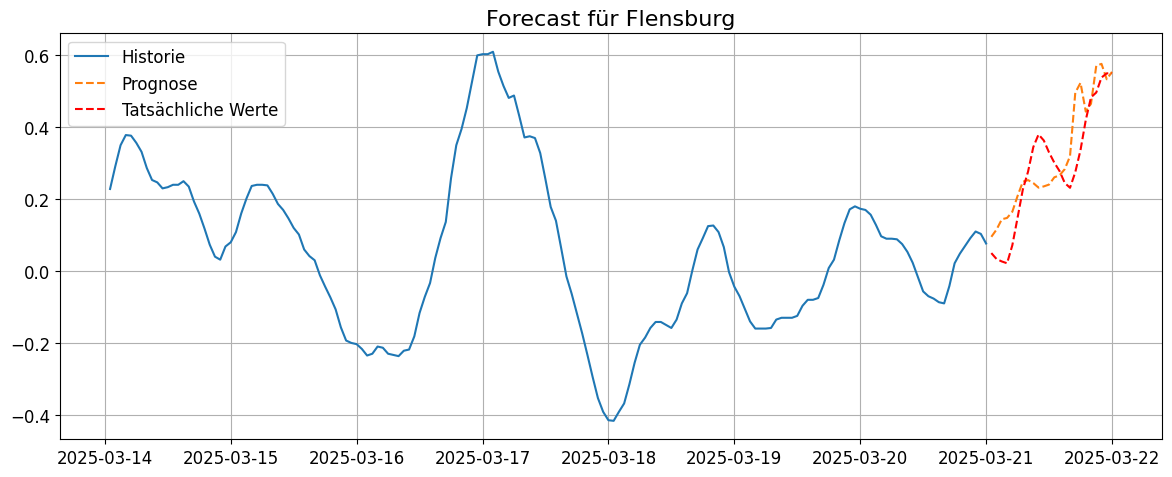

In [35]:
import matplotlib.pyplot as plt

def plot_forecast(original_df, pred_df, ts_id='Flensburg'):
    df_plot = original_df[original_df['unique_id'] == ts_id]
    pred_plot = pred_df[pred_df['unique_id'] == ts_id]
    
    plt.figure(figsize=(12, 5))
    # Nur die letzten 20 Zeitpunkte der Historie
    plt.plot(df_plot['ds'].iloc[-24*7:], df_plot['y'].iloc[-24*7:], label='Historie')
    plt.plot(pred_plot['ds'], pred_plot['RandomForestRegressor'], label='Prognose', linestyle='--')
    plt.plot(actual['ds'], actual['y'], label='Tatsächliche Werte', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Forecast für {ts_id}')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_forecast(train, predictions, ts_id='Flensburg')

## Optuna

🔁 3. TimeSeriesSplit vorbereiten

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, test_size=n_future)


🔍 4. Optuna Objective-Funktion

In [43]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from mlforecast import MLForecast

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "random_state": 42,
    }
    model = RandomForestRegressor(**params)
    
    rmses = []

    # Cross-Validation
    for train_idx, val_idx in tscv.split(df):
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        forecast = MLForecast(
            models=[model],
            freq='h',
            lags=[],
        )

        forecast.fit(df_train, static_features=[])

        horizon = len(df_val)
        preds = forecast.predict(horizon, X_df=df_val)

        # RMSE berechnen
        y_true = df_val['y'].values
        y_pred = preds['RandomForestRegressor'].values[:horizon]

        rmse = mean_squared_error(y_true, y_pred)
        rmses.append(rmse)

    return np.mean(rmses)


⚙️ 5. Studie starten

In [44]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

print("Beste Parameter:")
print(study.best_params)


[I 2025-06-02 13:52:18,794] A new study created in memory with name: no-name-cf912ade-53de-4254-b283-d2921c633306
[I 2025-06-02 13:54:33,617] Trial 0 finished with value: 0.01002417166014431 and parameters: {'n_estimators': 176, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.01002417166014431.
[I 2025-06-02 13:56:25,074] Trial 1 finished with value: 0.00968354840621303 and parameters: {'n_estimators': 131, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.00968354840621303.
[I 2025-06-02 13:56:47,695] Trial 2 finished with value: 0.012592890617516483 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.00968354840621303.


Beste Parameter:
{'n_estimators': 131, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}


✅ 6. Bestes Modell trainieren & vorhersagen

In [52]:
best_model = RandomForestRegressor(
    **study.best_params
)

final_forecast = MLForecast(
    models=[best_model],
    freq='h',
    lags=[],
    
)



tscv = TimeSeriesSplit(n_splits=3, test_size=n_future)
for train_idx, val_idx in tscv.split(df):
    pass



df_train = df.iloc[train_idx].copy()
df_test = df.iloc[val_idx].copy()
forecast_horizon = len(df_test)

final_forecast.fit(df_train, static_features=[])
final_preds = final_forecast.predict(forecast_horizon, X_df=df_test)
print(final_preds.head())


   unique_id                  ds  RandomForestRegressor
0  Flensburg 2025-03-21 01:00:00               0.147579
1  Flensburg 2025-03-21 02:00:00               0.156239
2  Flensburg 2025-03-21 03:00:00               0.162927
3  Flensburg 2025-03-21 04:00:00               0.163122
4  Flensburg 2025-03-21 05:00:00               0.168484


📈 7. Visualisierung

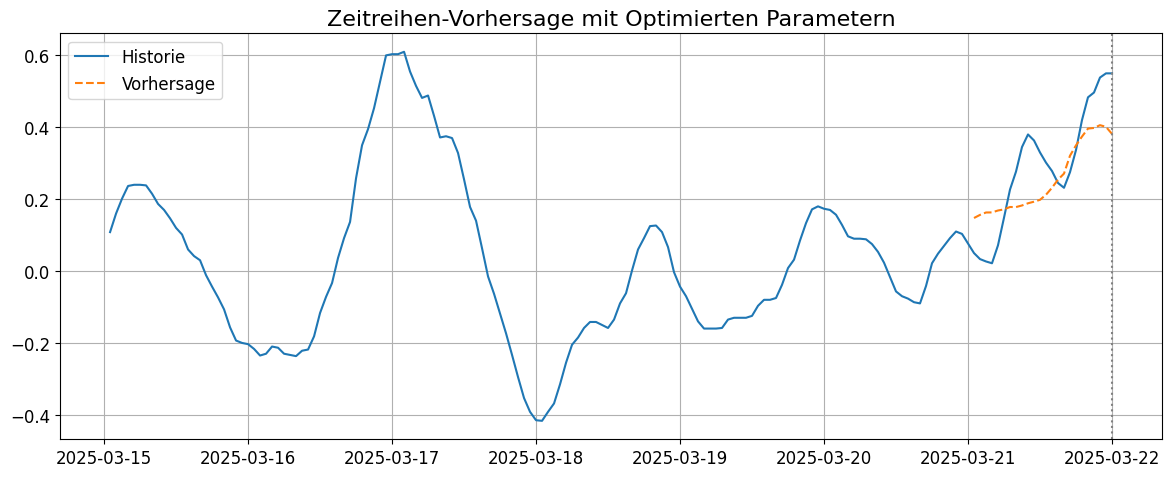

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['ds'].iloc[-24*7:], df['y'].iloc[-24*7:], label='Historie')
plt.plot(final_preds['ds'], final_preds['RandomForestRegressor'], label='Vorhersage', linestyle='--')
plt.axvline(df['ds'].iloc[-1], color='grey', linestyle=':')
plt.legend()
plt.title('Zeitreihen-Vorhersage mit Optimierten Parametern')
plt.grid()
plt.tight_layout()
plt.show()


🧠 Optional: Studie speichern & laden

In [ ]:
# import joblib

# # Speichern
# joblib.dump(study, 'optuna_study_rf.pkl')

# # Laden
# # study = joblib.load('optuna_study_rf.pkl')
